In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('resale-flat-price-2017-2021.csv')
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
111004,2021-10,YISHUN,EXECUTIVE,736,YISHUN ST 72,07 TO 09,162.0,Adjoined flat,1984,62 years 01 month,908000.0
111005,2021-10,YISHUN,EXECUTIVE,834,YISHUN ST 81,04 TO 06,154.0,Maisonette,1988,65 years 04 months,756000.0
111006,2021-10,YISHUN,EXECUTIVE,828,YISHUN ST 81,01 TO 03,145.0,Apartment,1988,65 years 04 months,715000.0
111007,2021-10,YISHUN,EXECUTIVE,826,YISHUN ST 81,07 TO 09,145.0,Apartment,1988,65 years 04 months,750000.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111009 entries, 0 to 111008
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                111009 non-null  object 
 1   town                 111009 non-null  object 
 2   flat_type            111009 non-null  object 
 3   block                111009 non-null  object 
 4   street_name          111009 non-null  object 
 5   storey_range         111009 non-null  object 
 6   floor_area_sqm       111009 non-null  float64
 7   flat_model           111009 non-null  object 
 8   lease_commence_date  111009 non-null  int64  
 9   remaining_lease      111009 non-null  object 
 10  resale_price         111009 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 9.3+ MB


As `df.info()` shows, there are no missing values, thus making data preparation slightly easier. Before analyzing the data further, split them into test and training data.

As prices are likely to be different depending on the location, to ensure enough samples for each town are represented in the train/test datasets, `train_test_split` is given the `stratify` parameter. Such spliting is known as stratified sampling.

In [3]:
from sklearn.model_selection import train_test_split

def split_train_test(df):
    train, test = train_test_split(df, test_size=0.2, stratify=df[['town']])
    return (train.drop('resale_price', axis=1), train['resale_price'],
            test.drop('resale_price', axis=1), test['resale_price'])

trainX, trainy, testX, testy = split_train_test(df)

Continuing data analysis with the training data; first, let's convert `remaining_lease` from text to float:

In [4]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
import re

def convert_remaining_lease_to_years(df):
    pattern = re.compile(r'^(\d+)\D+(\d+)?')
    
    def convert(s):
        m = pattern.match(s)
        years = int(m[1], base=10)
    
        if m.lastindex == 1:
            return years
        else:
            return round(years + float(m[2]) / 12, 1)
        
    df['remaining_lease'] = df['remaining_lease'].apply(convert)
    
    return df

trainX_copy = trainX.copy().pipe(convert_remaining_lease_to_years)
trainX_copy.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease
80455,2020-10,BEDOK,3 ROOM,108,BEDOK NTH RD,04 TO 06,67.0,New Generation,1977,55.8
58195,2019-09,YISHUN,4 ROOM,411,YISHUN RING RD,07 TO 09,104.0,Model A,1993,72.4
27946,2018-05,TAMPINES,EXECUTIVE,937,TAMPINES AVE 5,04 TO 06,146.0,Maisonette,1988,69.3
35902,2018-09,PUNGGOL,3 ROOM,624C,PUNGGOL CTRL,07 TO 09,69.0,Model A,2014,94.6
71263,2020-06,CHOA CHU KANG,EXECUTIVE,690B,CHOA CHU KANG CRES,07 TO 09,125.0,Apartment,2003,81.9


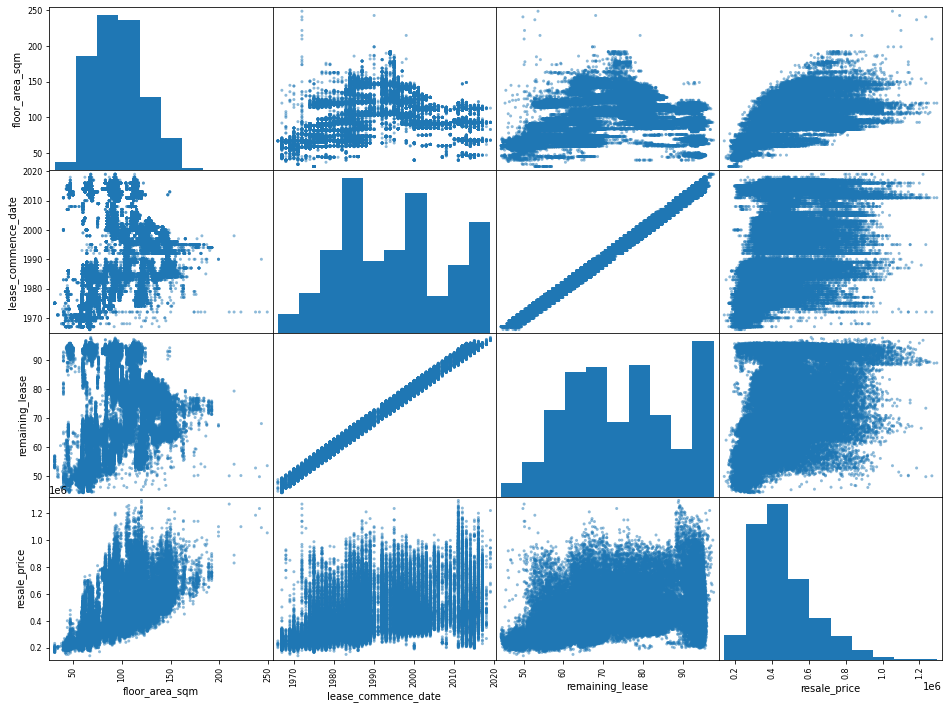

In [5]:
trainX_copy['resale_price'] = trainy
pd.plotting.scatter_matrix(trainX_copy, figsize=(16,12))
plt.show()

Create a transformation [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to simplify the transformation of data. The transformation pipeline has two steps:
* Convert `remaining_lease` from text to floating number
* Apply [column transformation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) on:
  * Numerical columns with [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  * Categorical columns (selected) with [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
  
After creating and fitting the transformation pipeline, further transformation on test and production data is simply `transformer.transform(<input data>)`.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def create_transformation_pipeline(df):
    return Pipeline([
        ('remaining-lease-converter', FunctionTransformer(convert_remaining_lease_to_years)),
        ('column-transformer', ColumnTransformer([
            ('scaler', StandardScaler(), ['lease_commence_date', 'remaining_lease', 'floor_area_sqm']),
            ('one-hot', OneHotEncoder(), ['town', 'flat_type', 'storey_range', 'flat_model'])
        ]))
    ])

transformer = create_transformation_pipeline(trainX)
trainX_encoded = transformer.fit_transform(trainX)
trainX_encoded

<88807x73 sparse matrix of type '<class 'numpy.float64'>'
	with 621649 stored elements in Compressed Sparse Row format>